## Install packages

```
install.packages("rstanarm", repos = "https://cloud.r-project.org", dependencies = TRUE)
```

In [1]:
source("get_data.R", verbose = FALSE)
Loans <- get_loans_data()
dim(Loans)

[1] 38607     7

In [2]:
training <- Loans[1:10000, ]
testing  <- Loans[-c(1:10000), ]
table(training$y)


NoProblem   Problem 
     8442      1558 

In [3]:
summary(training[,c("loan_amnt", "annual_inc")])

   loan_amnt       annual_inc     
 Min.   : 1000   Min.   :   6000  
 1st Qu.: 6000   1st Qu.:  43200  
 Median :11500   Median :  60000  
 Mean   :12942   Mean   :  71084  
 3rd Qu.:17625   3rd Qu.:  85000  
 Max.   :35000   Max.   :1782000  

In [4]:
with(training, table(term, home_ownership, emp_length != 0))

, ,  = FALSE

            home_ownership
term         MORTGAGE NONE OTHER  OWN RENT
   36 months      173    0     0   45  469
   60 months       97    0     0   15  141

, ,  = TRUE

            home_ownership
term         MORTGAGE NONE OTHER  OWN RENT
   36 months     2642    0     0  427 2861
   60 months     1727    0     0  216 1187


## Use rstanarm

In [5]:
library(rstanarm)

Loading required package: Rcpp
rstanarm (Version 2.13.1, packaged: 2016-11-20 16:59:31 UTC)
- Do not expect the default priors to remain the same in future rstanarm versions.
Thus, R scripts should specify priors explicitly, even if they are just the defaults.
- For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores())


In [6]:
options(mc.cores = parallel::detectCores())

In [7]:
y_tilde <- with(training, rbinom(nrow(training), size = 1, 
                                prob = ifelse(emp_length == 0, 0.5, 0.1)))
table(y_tilde)

y_tilde
   0    1 
8633 1367 

In [8]:
post_sim <- stan_glm(y_tilde ~ I(training$emp_length != 0), 
                     family = binomial(link = "logit"),
                     prior = normal(), prior_intercept = normal())

In [9]:
post <- stan_glm(y ~ log(loan_amnt) + term + home_ownership +
                   log(annual_inc) + I(emp_length != 0), 
                 family = binomial(link = "logit"), data = training,
                 prior = normal(), prior_intercept = normal(), QR = TRUE)

In [10]:
include <- c("log(loan_amnt)", "term 60 months", "home_ownershipOWN",
              "home_ownershipRENT", "log(annual_inc)", "I(emp_length != 0)TRUE")
plot(post, prob = 0.80, pars = include)

ERROR: Error in grid.Call(L_textBounds, as.graphicsAnnot(x$label), x$x, x$y, : X11 font -*-times-%s-%s-*-*-%d-*-*-*-*-*-*-*, face 2 at size 10 could not be loaded


plot without title

In [ ]:
launch_shinystan(post)


Creating shinystan object...

Hang on... preparing graphical posterior predictive checks for rstanarm model.
See help('shinystan', 'rstanarm') for how to disable this feature.
Warning message in pp_check.stanreg(object = structure(list(coefficients = structure(c(3.61200811704919, :
“Argument 'check' is deprecated. Specify 'plotfun' instead. In future versions the 'check' argument will be removed.”Warning message in pp_check.stanreg(object = structure(list(coefficients = structure(c(3.61200811704919, :
“Argument 'check' is deprecated. Specify 'plotfun' instead. In future versions the 'check' argument will be removed.”Warning message in pp_check.stanreg(object = structure(list(coefficients = structure(c(3.61200811704919, :
“Argument 'check' is deprecated. Specify 'plotfun' instead. In future versions the 'check' argument will be removed.”Warning message in pp_check.stanreg(object = structure(list(coefficients = structure(c(3.61200811704919, :
“Argument 'check' is deprecated. Specify 'pl

In [12]:
help(launch_shinystan)


Drawing from prior...


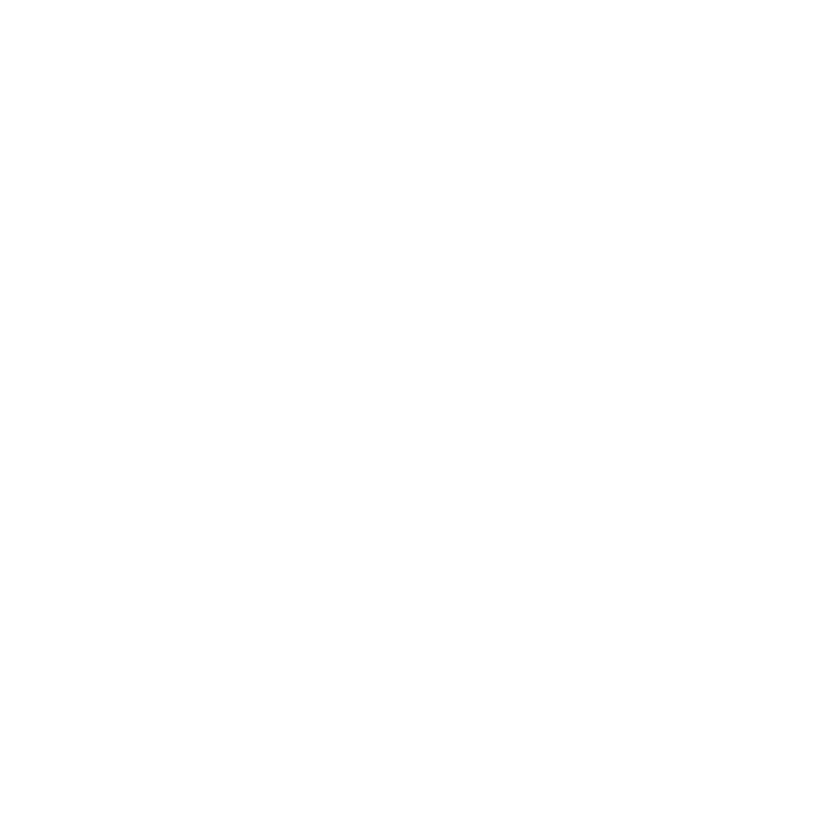

In [13]:
posterior_vs_prior(post, prob = 0.50, regex_pars = "^[h]")

In [14]:
ppd <- posterior_predict(post, newdata = testing, draws = 500)
profit <- sapply(1:ncol(ppd), FUN = function(i) {
  ifelse(ppd[,i] == 1, -testing$loan_amnt[i], testing$installment[i] *
           ifelse(testing$term[i] == "36 months", 36, 60) -
         testing$loan_amnt[i])
})

In [15]:
par(mar = c(5,4,1,1), las = 1)
hist(rowSums(profit) / sum(testing$loan_amnt), prob = TRUE, main = "Testing Dataset", 
     xlab = "Profit Margin")

ERROR: Error in grDevices::replayPlot(obj): X11 font -adobe-helvetica-%s-%s-*-*-%d-*-*-*-*-*-*-*, face 2 at size 14 could not be loaded


Plot with title “Testing Dataset”

In [16]:
post2 <- update(post, formula. = . ~ . - I(emp_length != 0))
loo(post)

Computed from 4000 by 10000 log-likelihood matrix

         Estimate    SE
elpd_loo  -4117.3  60.8
p_loo         6.5   0.2
looic      8234.5 121.7

All Pareto k estimates OK (k < 0.5)

In [17]:
loo(post2)


Computed from 4000 by 10000 log-likelihood matrix

         Estimate    SE
elpd_loo  -4116.4  60.8
p_loo         5.6   0.1
looic      8232.7 121.6

All Pareto k estimates OK (k < 0.5)